In [4]:
import tensorflow as tf
from tensorflow.keras import layers, datasets, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os
from glob import glob

Hyper parameters

In [5]:
#image dimensions
HEIGHT = 128
WIDTH = 128

#training and validation size of indian roads dataset
train_len = 2475
val_len = 752

#hyperparameters for loading images
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [6]:
#path to your dataset
dataset_path = "indian_roads_archive/Indian_road_data/Indian_road_data"
os.path.exists(dataset_path)

True

# Building the input pipeline

Loading images directly into numpy give numpy array gives OOM(out of memory) error, so we are using tensorflow's datapipeline to load data in batches

In [7]:
#load training and validation image paths into datapipeline
x_train = tf.data.Dataset.list_files(os.path.join(dataset_path,"Raw_images","train","*","*.jpg"),shuffle=False)
y_train = tf.data.Dataset.list_files(os.path.join(dataset_path,"Masks","train","*","*.png"), shuffle=False)
x_valid = tf.data.Dataset.list_files(os.path.join(dataset_path,"Raw_images","val","*","*.jpg"),shuffle=False)
y_valid = tf.data.Dataset.list_files(os.path.join(dataset_path,"Masks","val","*","*.png"),shuffle=False)

In [8]:
#print samples
for x in x_train.take(2):
    print(x)

tf.Tensor(b'indian_roads_archive\\Indian_road_data\\Indian_road_data\\Raw_images\\train\\1_005\\1_005_frame0007_leftImg8bit.jpg', shape=(), dtype=string)
tf.Tensor(b'indian_roads_archive\\Indian_road_data\\Indian_road_data\\Raw_images\\train\\1_005\\1_005_frame0014_leftImg8bit.jpg', shape=(), dtype=string)


Get the images and masks from the paths and preprocess them into required dimensions

In [9]:
#images are loaded in rgb format and masks in grayscale
def process_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=3)
    img = tf.image.resize(img,(HEIGHT,WIDTH))
    img = img/255.0
    return img

def process_mask(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img,channels=1)
    img = tf.image.resize(img,(HEIGHT,WIDTH))
    img = img/255.0
    return img

The x_train and y_train are zipped into single input pipeline

In [10]:
#the map function applies the specified function to each of the data elements
x_train = x_train.map(process_image)
y_train = y_train.map(process_mask)
train_dataset = tf.data.Dataset.zip((x_train,y_train))
x_valid = x_valid.map(process_image)
y_valid = y_valid.map(process_mask)
valid_dataset = tf.data.Dataset.zip((x_valid,y_valid))

In [11]:
#get training and validation sizes
train_len = len(x_train)
valid_len = len(x_valid)
valid_len

752

#### Setting up parameters for training

Shuffle - shuffles the dataset randomly 

batch - specifies the batch size of the data

repeat - Once all the data is fed, the data is loaded from first again

prefetch - Enables parallel fetching of data by CPU while GPU trains the images

AUTOTUNE decides the prefetch time automatically

cache - saves the loaded data so that it need not be loaded again

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
valid_dataset = train_dataset.cache().prefetch(AUTOTUNE)

Function to display the i-th image

In [13]:
def show_image(i):
    #skip is used to skip the first k batches
    #take selects the first k batches
    batch = train_dataset.skip(i//BATCH_SIZE).take(1)
    for images, masks in batch:
        img = images[i%BATCH_SIZE];
        mask = masks[i%BATCH_SIZE];
        plt.figure(figsize=(4,2))

        plt.subplot(1,2,1)
        plt.imshow(img.numpy())
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(mask.numpy(),cmap = 'gray')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

Displaying Random Images from the Dataset

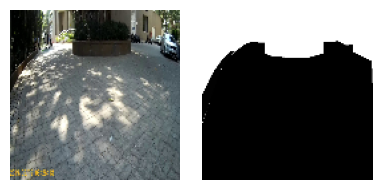

In [14]:
import random
show_image(random.randint(0,train_len))

# The Unet Model

<img src="https://miro.medium.com/v2/resize:fit:1400/1*f7YOaE4TWubwaFF7Z1fzNw.png" alt="Description" style="width:400px;height:auto;">


In [15]:
def conv_block(x,n_filters):
    x = layers.Conv2D(filters = n_filters, kernel_size = (3,3), padding='same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    x = layers.Conv2D(filters = n_filters, kernel_size = (3,3), padding='same', activation = 'relu', kernel_initializer = 'he_normal')(x)
    return x

In [16]:
def encoder_block(x,n_filters):
    f = conv_block(x,n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p

In [17]:
def decoder_block(x,conv_features,n_filters):
    x = layers.Conv2DTranspose(n_filters,kernel_size =(3,3), strides = 2, padding = 'same')(x)
    x = layers.concatenate([x, conv_features])
    x = layers.Dropout(0.3)(x)
    x = conv_block(x,n_filters)
    return x

In [18]:
def build_unet():
    inputs = tf.keras.layers.Input(shape=(128,128,3))

    f1, p1 = encoder_block(inputs,64)
    f2, p2 = encoder_block(p1,128)
    f3, p3 = encoder_block(p2,256)
    f4, p4 = encoder_block(p3,512)

    bottle_neck = conv_block(p4,1024)

    u1 = decoder_block(bottle_neck,f4,512)
    u2 = decoder_block(u1,f3,256)
    u3 = decoder_block(u2,f2,128)
    u4 = decoder_block(u3,f1,64)

    outputs = layers.Conv2D(filters = 1,kernel_size = 1, padding='same',activation = 'sigmoid')(u4)

    unet_model = tf.keras.Model(inputs,outputs,name='U-Net')

    return unet_model

In [19]:
model = build_unet()

In [20]:
model.compile(optimizer = 'adam',loss='binary_crossentropy',metrics=['accuracy'])

## Training the model

In [23]:
model = tf.keras.models.load_model('unet_2_model.h5')

In [34]:
EPOCHS = 10
STEPS_PER_EPOCH = train_len // BATCH_SIZE

VAL_SUBSPLITS = 5
VALIDATION_STEPS = valid_len // BATCH_SIZE // VAL_SUBSPLITS

training_history = model.fit(
    train_dataset,
    epochs = EPOCHS, 
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps =VALIDATION_STEPS,
    validation_data=valid_dataset
)

Epoch 1/10
38/38 [==============================] - 80s 2s/step - loss: 0.2317 - accuracy: 0.8523 - val_loss: 0.2066 - val_accuracy: 0.8854
Epoch 2/10
38/38 [==============================] - 100s 2s/step - loss: 0.1629 - accuracy: 0.8763 - val_loss: 0.1436 - val_accuracy: 0.8828
Epoch 3/10
38/38 [==============================] - 78s 2s/step - loss: 0.1402 - accuracy: 0.8837 - val_loss: 0.1334 - val_accuracy: 0.8962
Epoch 4/10
38/38 [==============================] - 78s 2s/step - loss: 0.1228 - accuracy: 0.8898 - val_loss: 0.1089 - val_accuracy: 0.8956
Epoch 5/10
38/38 [==============================] - 78s 2s/step - loss: 0.1095 - accuracy: 0.8937 - val_loss: 0.1046 - val_accuracy: 0.8989
Epoch 6/10
38/38 [==============================] - 78s 2s/step - loss: 0.1041 - accuracy: 0.8946 - val_loss: 0.1009 - val_accuracy: 0.9063
Epoch 7/10
38/38 [==============================] - 78s 2s/step - loss: 0.1013 - accuracy: 0.8957 - val_loss: 0.0905 - val_accuracy: 0.9077
Epoch 8/10
38/38 [=

Saving the model in .h5 file. I can also be saved as a folder

In [24]:
model.save('unet_2_model.h5')

In [25]:
for images, masks in valid_dataset.take(1):
    print(images.shape)  # Should print (batch_size, 128, 128, 3)
    print(masks.shape)  

(64, 128, 128, 3)
(64, 128, 128, 1)


Function to plot the training history

In [26]:
def plot_history(his):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))  # Create a 1x2 grid of subplots with total size 4x2 inches

    ax1.plot(his.history['loss'], label='train')
    ax1.plot(his.history['val_loss'], label='val')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    ax2.plot(his.history['accuracy'], label='train')
    ax2.plot(his.history['val_accuracy'], label='val')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

In [27]:
plot_history(training_history)

NameError: name 'training_history' is not defined

## Testing

Tests on random image from the validation dataset itself

In [28]:
import random
import matplotlib.pyplot as plt

def predict_image_from_val(i):
    batch = valid_dataset.skip(i // BATCH_SIZE).take(1)
    for images, masks in batch:
        img = images[i % BATCH_SIZE]
        mask = masks[i % BATCH_SIZE]
        
        output = model.predict(tf.expand_dims(img, axis=0))
        output = tf.squeeze(tf.cast(output>0.5,tf.uint8))
        plt.figure(figsize=(6, 2))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask, cmap='gray')
        plt.title("True Mask")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(output, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        
        print("Output:", output.shape)



1/1 [==============================] - 12s 12s/step


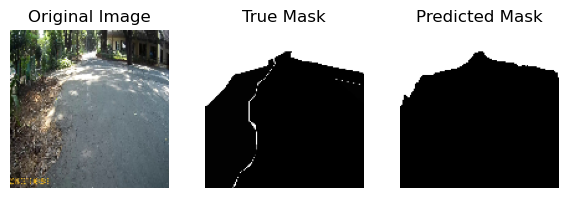

Output: (128, 128)
1/1 [==============================] - 0s 372ms/step


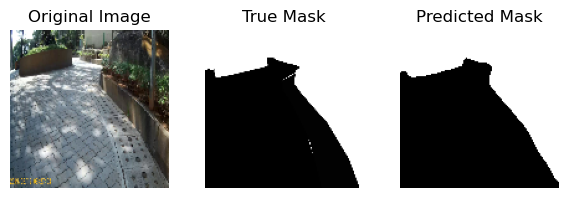

Output: (128, 128)
1/1 [==============================] - 0s 334ms/step


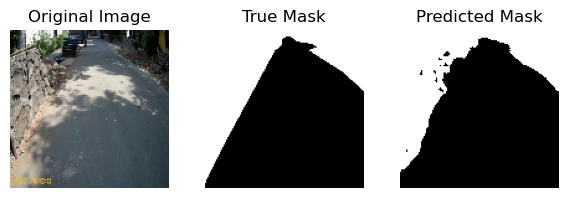

Output: (128, 128)
1/1 [==============================] - 0s 314ms/step


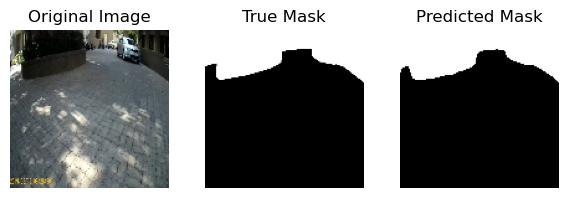

Output: (128, 128)
1/1 [==============================] - 0s 243ms/step


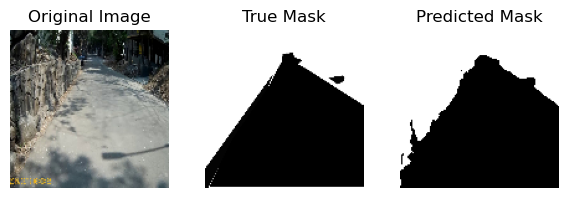

Output: (128, 128)
1/1 [==============================] - 0s 377ms/step


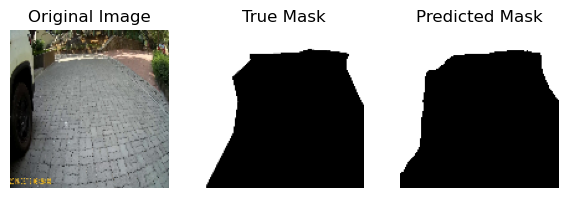

Output: (128, 128)
1/1 [==============================] - 0s 256ms/step


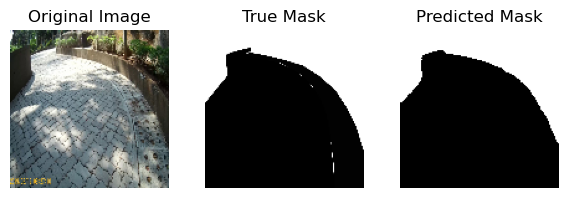

Output: (128, 128)
1/1 [==============================] - 0s 94ms/step


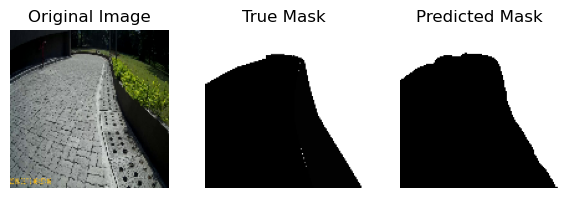

Output: (128, 128)
4.45 s ± 623 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
predict_image_from_val(random.randint(0, val_len))

Tests on any image from your device

In [30]:
def custom_image_test(path):
    def load_and_preprocess_image(image_path, target_size):
        # Load the image
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
        # Convert the image to an array
        image_array = tf.keras.preprocessing.image.img_to_array(image)
        # Normalize the image
        image_array = image_array / 255.0
        # Add batch dimension
        image_array = np.expand_dims(image_array, axis=0)
        return image_array
    
    image_path = path  #'1_005_frame0007_leftImg8bit.jpg'
    target_size = (128, 128)
    input_image = load_and_preprocess_image(image_path, target_size)
    
    predicted_mask = model.predict(input_image)
    
    # Corrected casting to tf.uint8 and squeezing dimensions for visualization
    predicted_mask = tf.squeeze(tf.cast(predicted_mask > 0.5, tf.uint8))
    
    plt.figure(figsize=(4, 2))
    
    plt.subplot(1, 2, 1)
    plt.imshow(input_image.squeeze())
    plt.title("Original Image")
    plt.axis("off")
    
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()
    
    print("Output:", predicted_mask.shape)

1/1 [==============================] - 0s 31ms/step


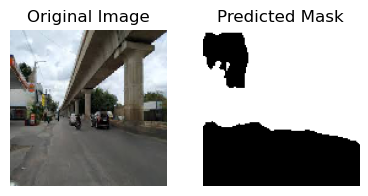

Output: (128, 128)
1/1 [==============================] - 0s 47ms/step


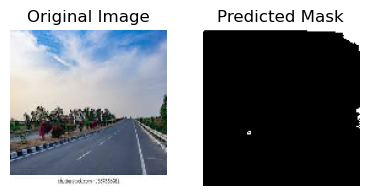

Output: (128, 128)
1/1 [==============================] - 0s 47ms/step


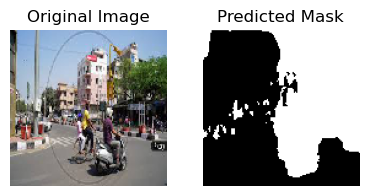

Output: (128, 128)
1/1 [==============================] - 0s 47ms/step


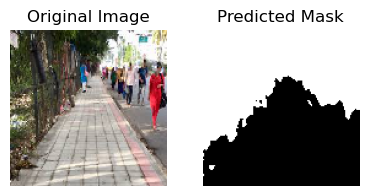

Output: (128, 128)
1/1 [==============================] - 0s 47ms/step


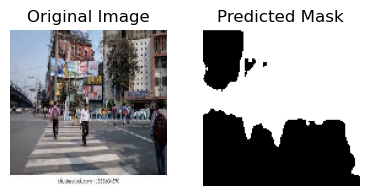

Output: (128, 128)


In [31]:
import glob
for path in glob.glob('custom_test_images/*.jpg'):
    custom_image_test(path)